**Bank Deposit Prediction**

Data Understanding

        The dataset pertains to direct marketing campaigns conducted by a Portuguese banking institution. These campaigns involved phone calls, often requiring multiple contacts with the same client to determine if they would subscribe to a bank term deposit (indicated as 'yes') or not (indicated as 'no').

Objective:

        The goal is to classify whether a client will subscribe to a term deposit (variable y) based on various features.

Variable Definitions:

        age : Age of bank customers, ranging from 18 to 95.
        job : Type of job (e.g., housemaid, blue-collar, management, retired).
        marital : Marital status (e.g., married, single, divorced).
        education: Education level (e.g., high school, illiterate, university degree).
        default : Indicates if the customer has credit in default.
        balance : Average yearly balance of customers.
        housing : Indicates whether the customer has a housing loan.
        loan : Indicates whether the customer has a personal loan.
        contact : Type of communication used to contact the customer (e.g., cellular, telephone).
        day : Day of the week when the last contact was made(Date).
        month : Month of the last contact..
        duration : Duration of the last call in seconds.
        campaign : Number of contacts made during this campaign for this client (numeric, includes the last contact).
        pdays : Number of days since the client was last contacted in a previous campaign.
        previous : Number of contacts made before this campaign for this client.
        poutcome : Outcome of the previous marketing campaign
        y : Indicates whether the client subscribed to a term deposit (yes/no).f the week

- Importing Useful Libraries

In [93]:
import pandas as pd
import seaborn as sns
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import PowerTransformer
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix


from sklearn import metrics 
from sklearn.model_selection import  train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier


warnings.filterwarnings("ignore")
%matplotlib inline

- Importing Data Frame

In [94]:
train_df = pd.read_csv(r"C:\Users\JOY\Downloads\archive\Train.csv")
test_df = pd.read_csv(r"C:\Users\JOY\Downloads\archive\Test.csv")

df = pd.concat([train_df,test_df],ignore_index = True)

#df.to_csv("bank.csv",index = False)

df.head()
df.shape

(49732, 17)

- Dropping Duplicate Rows

In [95]:
df.drop_duplicates(inplace=True)
print(f"The no.of rows in the dataset is {df.shape[0]} and no.of columns of the dataset is {df.shape}")

The no.of rows in the dataset is 45211 and no.of columns of the dataset is (45211, 17)


-  Check unique values of target varaible

In [96]:
df["day"].unique()

array([ 5,  6,  7,  8,  9, 12, 13, 14, 15, 16, 19, 20, 21, 23, 26, 27, 28,
       29, 30,  2,  3,  4, 11, 17, 18, 24, 25,  1, 10, 22, 31],
      dtype=int64)

In [97]:
df["previous"].unique()

array([  0,   3,   1,   4,   2,  11,  16,   6,   5,  10,  12,   7,  18,
         9,  21,   8,  14,  15,  26,  37,  13,  25,  20,  27,  17,  23,
        38,  29,  24,  51, 275,  22,  19,  30,  58,  28,  32,  40,  55,
        35,  41], dtype=int64)

In [98]:

df['y'].value_counts()

y
no     39922
yes     5289
Name: count, dtype: int64

- # define numerical & categorical columns

In [99]:

numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

# print columns
print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 7 numerical features : ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

We have 10 categorical features : ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']


# Converting unknown values and -1 values to NaN values

In [100]:
# Converting the values with -1 value to Null
df.pdays[df.pdays == -1] = np.nan

# Assigning 'NaN' to 'unknown' values to col
col = ['job', 'education', 'contact', 'poutcome']

for column in col:
    df[column].replace('unknown', np.nan, inplace=True)

# Viewing percentage of missing values
print("Percentage of Missing Values")
round((df.isnull().sum()[df.isnull().sum()>0]*100)/df.shape[0],2)

Percentage of Missing Values


job           0.64
education     4.11
contact      28.80
pdays        81.74
poutcome     81.75
dtype: float64

- # Plotting Missing values count for each column

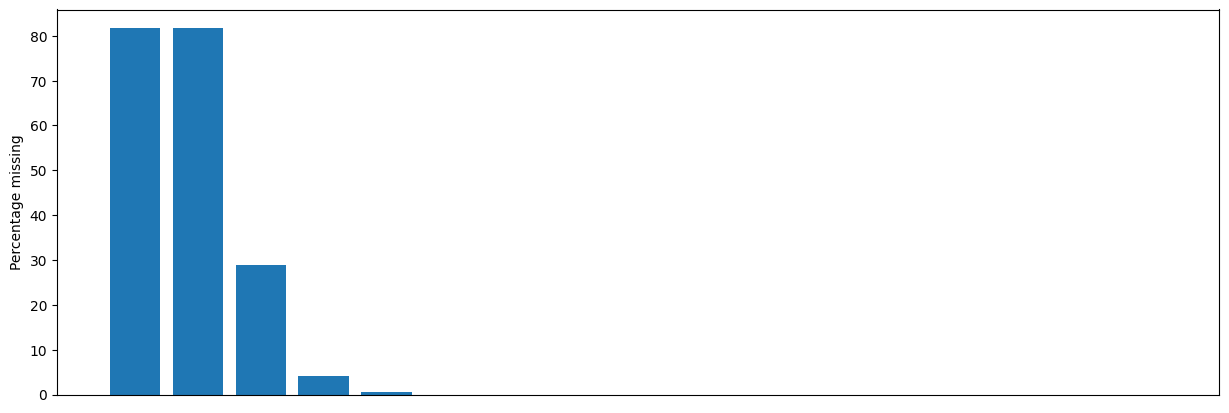

In [101]:

fig, ax = plt.subplots(figsize=(15,5))

missing = df.isna().sum().div(df.shape[0]).mul(100).to_frame().sort_values(by=0, ascending = False)

ax.bar(missing.index, missing.values.T[0])
plt.xticks([])
plt.ylabel("Percentage missing")
plt.show()

- ## Dropping columns which has more than 70% of missing values

In [102]:

dropcols = missing[missing[0]>70]
dropcols

,0
poutcome,81.747805
pdays,81.736745


In [103]:
df.drop(list(dropcols.index), axis=1, inplace=True)

- Check shape of the dataset after dropping columns

In [104]:

df.shape

(45211, 15)

### Check the total percentage of missing values of full dataset after dropping columns with more than 70% of missing values

In [105]:
missing_values_count= df.isnull().sum()
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
print(f"Percentage of total missing cells in the data {(total_missing/total_cells) * 100}%")

Percentage of total missing cells in the data 2.236181460264095%


- # Outliers  

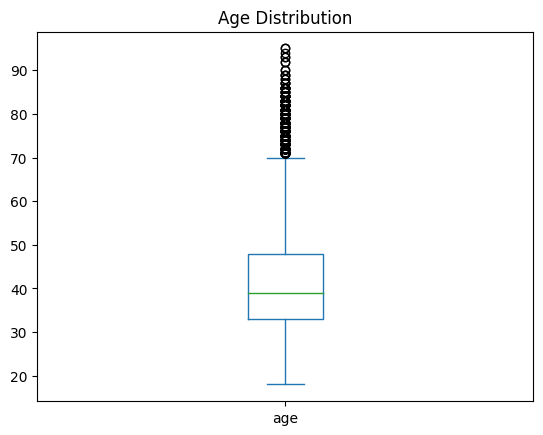

In [106]:
# 1. Age
# Viewing the box plot of Age
plt.title('Age Distribution')
df.age.plot.box()
plt.show()

- The age column contains continuous values. The box plot indicates outliers for ages above 70, which is due to their lower frequency compared to younger ages. However, these ages are legitimate as there are indeed a few people older than 70

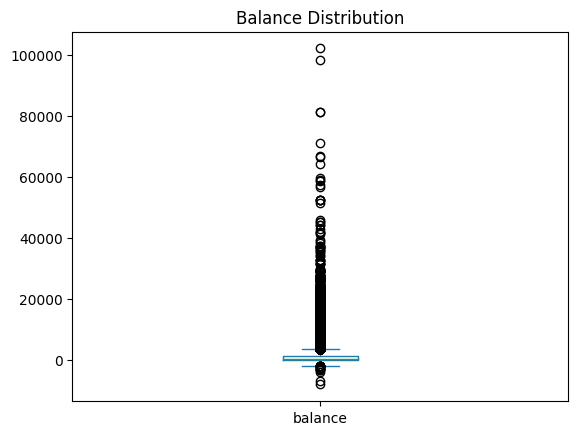

In [107]:
# 2. Balance
plt.title('Balance Distribution')
df.balance.plot.box()
plt.show()

In [108]:
# Viewing the number of people with more than 40 k average balance
df[df.balance > 40000].shape

(28, 15)

- The average annual balance is 1362 , while the maximum is around 1 lakh, lets view the people with more than 50k deposits.

- There are only a handful of people with more than 50 k bank balance but the data is legitimate and is not mistaken, it might help the model, hence leaving the values and proceeding to the next.

- # Creating sub plots
- Plotting first chart for Subscription Status of customer duration more than 2k
- Plotting second chart with Subscription Status of all customers


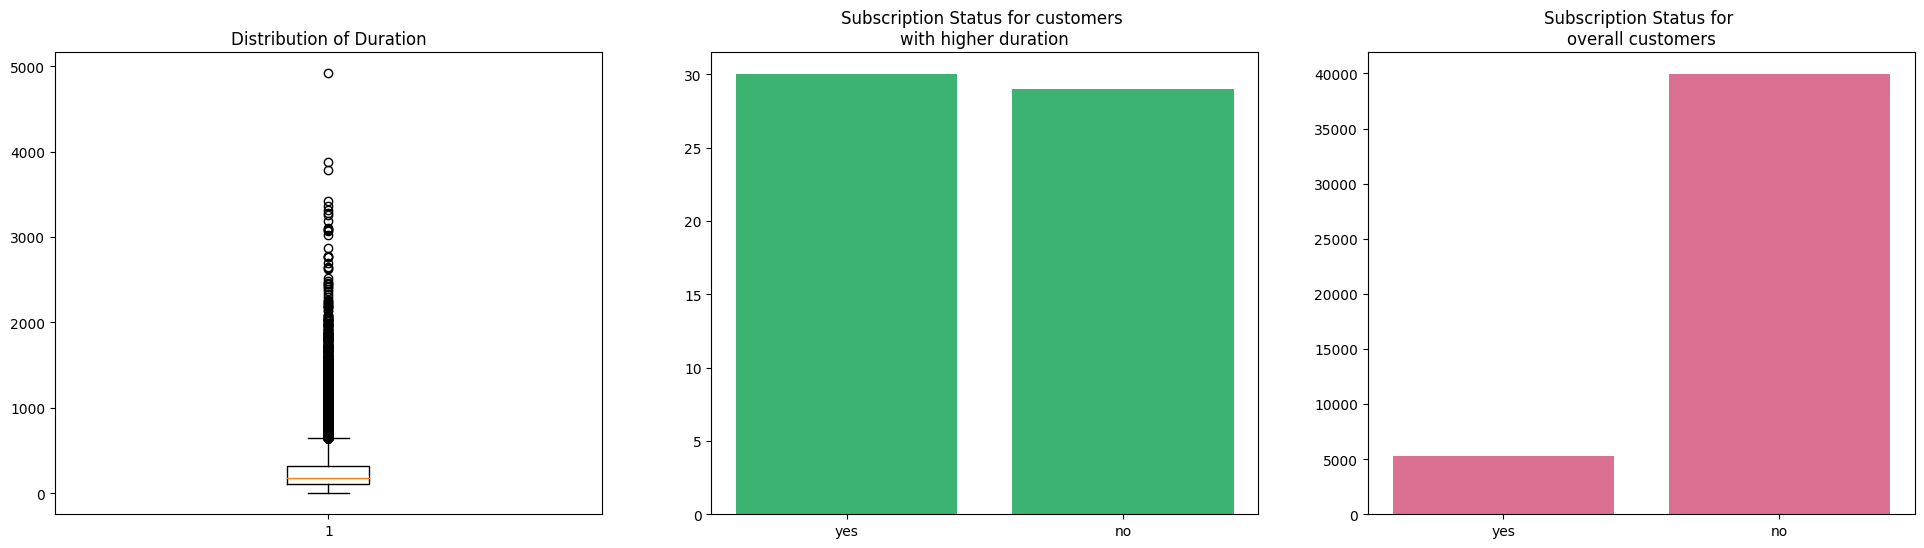

In [109]:

fig,axes = plt.subplots(1,3,figsize = [24,6])

# 3. Duration
axes[0].boxplot(df.duration)
axes[0].set_title('Distribution of Duration')

# Plotting first chart for Subscription Status of customer duration more than 2k
data = df.y[df.duration > 2000].value_counts()
axes[1].bar(data.index, data.values, color = 'mediumseagreen')
axes[1].set_title('Subscription Status for customers \nwith higher duration')

# Plotting second chart with Subscription Status of all customers
data = df.y.value_counts()
axes[2].bar(data.index[::-1], data.values[::-1], color = 'palevioletred')
axes[2].set_title('Subscription Status for \noverall customers')

plt.show()

- From the above box plot, we observe outliers in the data. Further analysis using bar charts reveals that the overall subscription rate is only 11%. However, when filtering for durations greater than 2000 seconds i.e 33 mins, the subscription rate is slightly higher or equal. Therefore, these findings are meaningful and should be considered in the machine learning model.

- # Exploratory Data Analysis (EDA)

- Bivariate Analysis

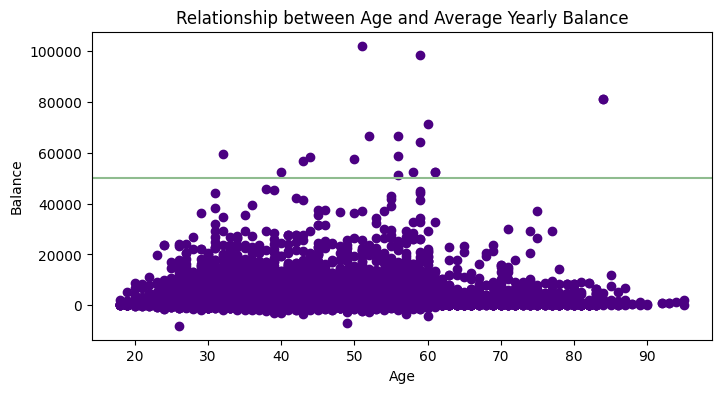

In [110]:
 #Age and balance
plt.figure(figsize = [8,4])
plt.title('Relationship between Age and Average Yearly Balance')
plt.scatter(df.age, df.balance, color  = 'indigo')
plt.xlabel('Age')
plt.axhline(y = 50000, color='darkseagreen')
plt.ylabel('Balance')
plt.show()

From the data, we observe a clear positive relationship where mostly individuals aged over 40 tend to have an annual average balance exceeding 50,000.

- Marital vs term deposit subscriptions

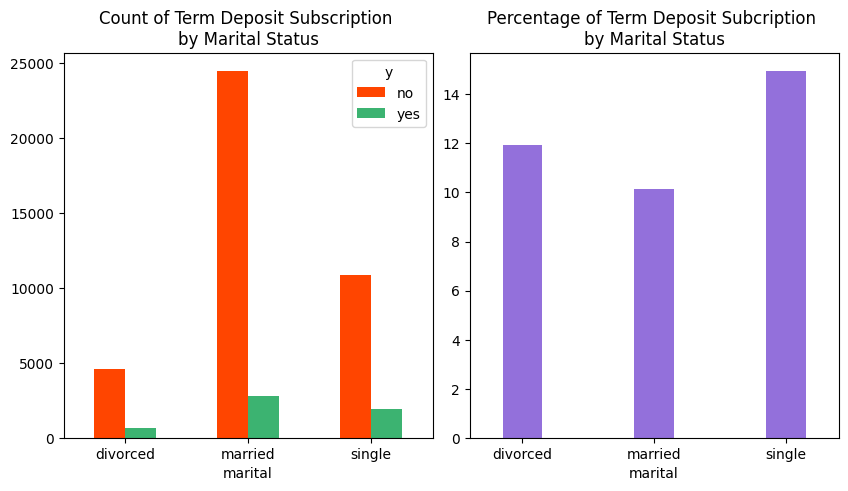

In [111]:

# Creating subplots
figure, axes = plt.subplots(1,2, figsize=[10,5])

# Creating crosstab table
bary = pd.crosstab(df.marital , df.y)

# Visualizing the table
bary.plot.bar(ax=axes[0],color = ['orangered' , 'mediumseagreen'])
axes[0].set_title('Count of Term Deposit Subscription \nby Marital Status')
axes[0].set_xticklabels(bary.index, rotation = 0)


# Plotting the percentage subscription rate in each category
yes_y_marital = df.marital[df.y == 'yes'].value_counts()
desired_order = ['divorced', 'married', 'single']
yes_y_marital = yes_y_marital.reindex(desired_order, fill_value=0)
marital = df.marital.value_counts()
calculation = ((yes_y_marital / marital)*100)

# Visualizing data
calculation.plot.bar(width = 0.3, color = 'mediumpurple')
axes[1].set_title('Percentage of Term Deposit Subcription \nby Marital Status')
axes[1].set_xticklabels(yes_y_marital.index , rotation = 0)

plt.subplots_adjust(wspace=0.1) 
plt.show()



- Married individuals account for a higher total number of term deposit subscriptions but the percentage of married people subscribing is lower compared to singles.
- Singles, followed by divorced individuals, are more likely to invest in term deposits relative to their group size.

- Job vs term deposit subscriptions (subplots)

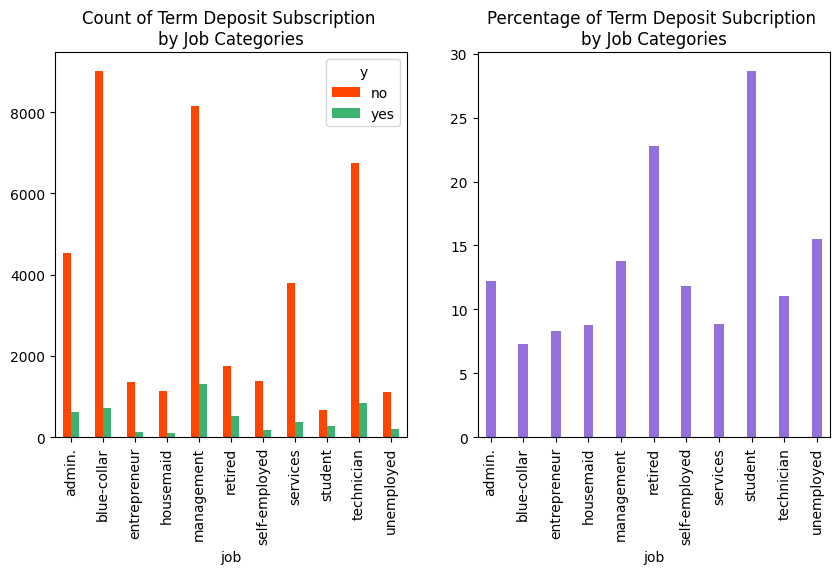

In [112]:
figure, axes = plt.subplots(1,2, figsize=[10,5])

# Creating crosstab table
bary = pd.crosstab(df.job , df.y)

# Visualizing the table
bary.plot.bar(ax=axes[0],color = ['orangered' , 'mediumseagreen'])
axes[0].set_title('Count of Term Deposit Subscription \nby Job Categories')
axes[0].set_xticklabels(bary.index, rotation = 90)


# Plotting the percentage subscription rate in each category
yes_y_job = df.job[df.y == 'yes'].value_counts()
desired_order = bary.index
yes_y_job= yes_y_job.reindex(desired_order, fill_value=0)
job = df.job.value_counts()
calculation = ((yes_y_job / job)*100)

# Visualizing data
calculation.plot.bar(width = 0.3, color = 'mediumpurple')
axes[1].set_title('Percentage of Term Deposit Subcription \nby Job Categories')
axes[1].set_xticklabels(yes_y_job.index , rotation = 90)

plt.show()

- Despite their smaller numbers (less than a thousand), students have a high subscription rate of over 25%.
- With around 2,300 individuals, retirees have a subscription rate of approximately 22%.
- Blue-collar Workers: Although they are the largest customer group at the bank, blue-collar workers have the lowest subscription rate at just 7%.

-  # Multivariate Analysis

- Contribution of Balance and Job Titles towards Term deposit subscription

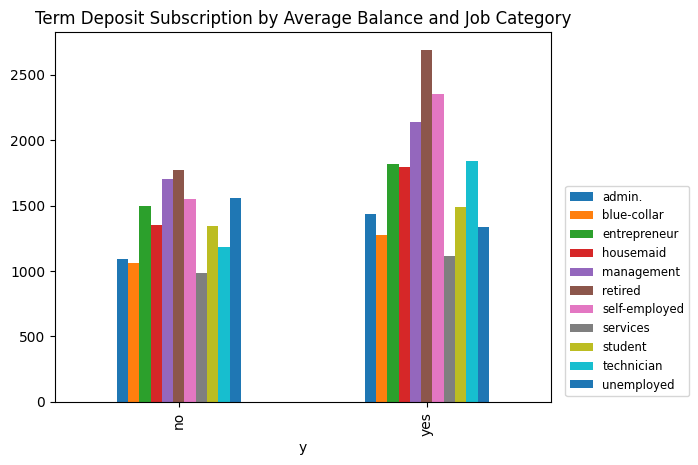

In [113]:
 
pd.pivot_table(df , values = 'balance' , index = 'y' , columns = 'job', aggfunc = 'mean').plot.bar()
plt.legend(loc='lower right',fontsize='small',bbox_to_anchor=(1.29, 0))
plt.title("Term Deposit Subscription by Average Balance and Job Category")
plt.show()

- From the chart, it is evident that individuals with higher average balances are more likely to subscribe to term deposits, a trend particularly noticeable among retirees. Although there are variations across job categories, such as unemployed individuals, this suggests that other factors may also affect subscription rates. Overall, a higher balance seems to have a positive influence on term deposit subscriptions.

-  Plotting the duration vs the months vs the Subscription decision

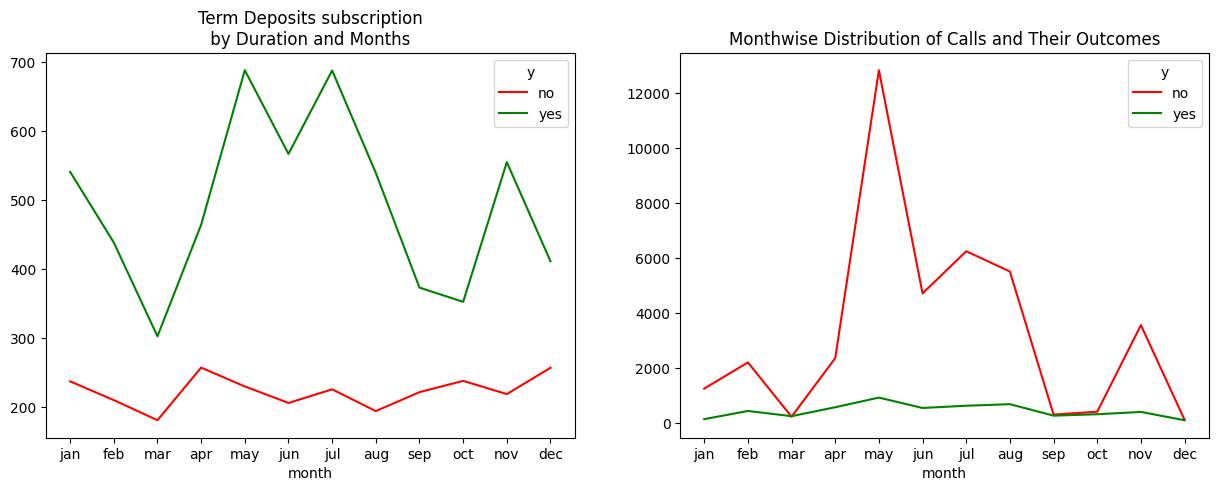

In [114]:
figure, axes = plt.subplots(1,2 , figsize = (15,5))

#creating pivot table
md_subscription = pd.pivot_table(df, values = 'duration', columns = 'y' , index = 'month').reindex(['jan' , 'feb' , 'mar' , 'apr' , 'may' , 'jun' , 
                                                                                                    'jul' , 'aug', 'sep' , 'oct', 'nov' , 'dec'])

#Plotting the line chart of duration across months
md_subscription.plot.line(ax = axes[0],color = ['red' , 'green'])
axes[0].set_xticks( ticks = range(len(md_subscription.index)) , labels = md_subscription.index)
axes[0].set_title('Term Deposits subscription\n by Duration and Months ')

# calculating table
no_ofcalls = pd.pivot_table(df,columns = 'y' ,values = 'job', index = 'month' , aggfunc = 'count').reindex(md_subscription.index)

#plotting the table
no_ofcalls.plot.line(ax = axes[1],color = ['red' , 'green'])
axes[1].set_xticks( ticks = range(len(no_ofcalls .index)) , labels = no_ofcalls .index)
axes[1].set_title("Monthwise Distribution of Calls and Their Outcomes")

plt.show()

- Calculating the percentage of people spoke over 300 seconds who subscribed

In [115]:

print('Percentage of people with duration > 300 among the total subscription:',\
      round(df.y[(df.duration>300) &(df.y == 'yes')].shape[0]/df.y[df.y == 'yes'].shape[0]*100,2),'%')

Percentage of people with duration > 300 among the total subscription: 65.38 %


- There is a noticeable difference in call durations between subscribers and non-subscribers. Subscribers have a minimum average call duration of 302 seconds per month, while non-subscribers have a maximum average call duration of 257 seconds. This suggests that longer call durations are strongly associated with higher subscription rates.
- The right chart indicates that the subscription rate remains relatively stable throughout the months, whereas there is significant fluctuation in the number of non-subscribed calls. Notably, rejections peak around April and May, while in September and October, the numbers of 'yes' and 'no' responses are almost equal.


## Visualization of unique values in Target variable

Positive: 5289, Negative: 39922


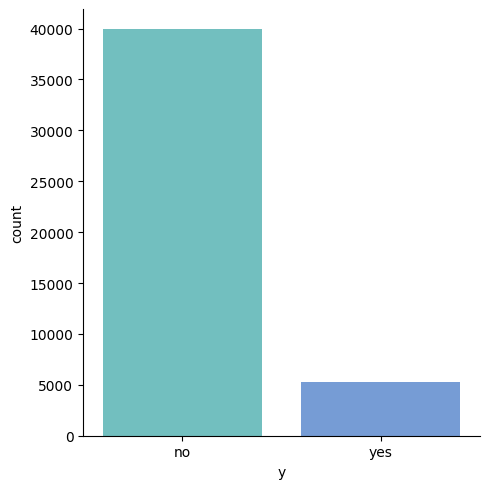

In [116]:
pos = df[df['y']=='yes'].shape[0]
neg = df[df['y']=='no'].shape[0]
print("Positive: " + str(pos) + ", Negative: " + str(neg))
sns.catplot(data=df, x="y", kind="count", palette="winter_r", alpha=.6)
plt.show()

**Report**
- The target classes are highly imbalanced
- Class imbalance is a scenario that arises when we have unequal distribution of class in a dataset i.e. the no. of data points in the "no" class (majority class) very large compared to that of the "yes" class (minority class)
- If the imbalanced data is not treated beforehand, then this will degrade the performance of the classifier model. 
- Hence we should handle imbalanced data with certain methods.



## Create Functions for model training and evaluation

In [117]:
def evaluate_clf(true, predicted):
    '''
    This function takes in true values and predicted values
    Returns: Accuracy, F1-Score, Precision, Recall, Roc-auc Score
    '''
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

### Plot  distribution of all Independent Numerical variables

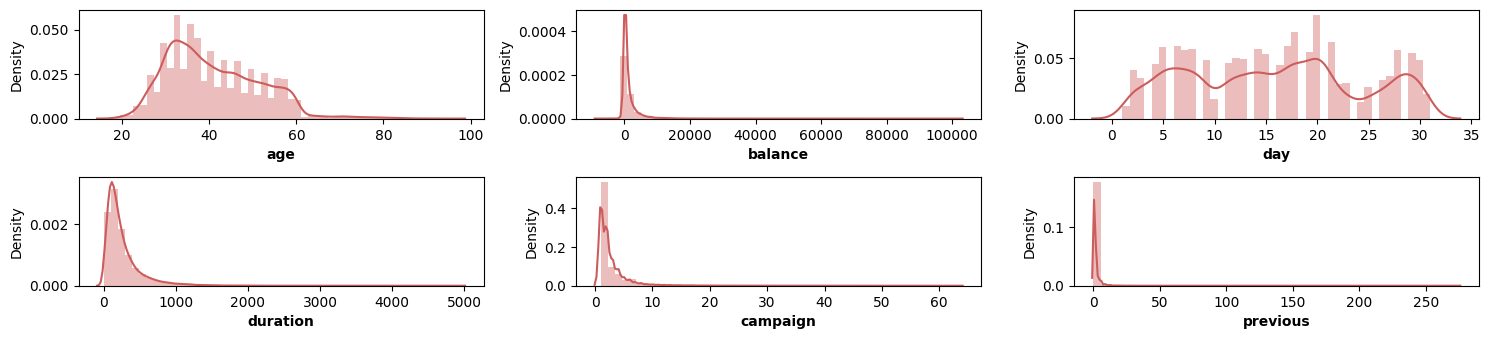

In [118]:
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']

plt.figure(figsize=(15, 100))
for i, col in enumerate(numeric_features):
    plt.subplot(60, 3, i+1)
    sns.distplot(x=df[col], color='indianred')
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

**Report**
- As per the above plot most of the features are not normally distributed.
- Transformation of data is not of prime importance since it is a classification problem.
- Interpreting each and every column is not necessary as this is sensor data.

# Evaluate Model on Different experiments

In [119]:
# Splitting X and y for all Experiments
X= df.drop('y', axis=1)
y = df['y']

- **Manually Encoding Target Variable**

In [120]:
y= y.replace({'yes': 1, 'no': 0})

In [121]:
X

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,previous
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,0
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,0
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,0
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,0
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,0
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,3
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,0


### Experiment: 2 =  Imputing with Strategy Mode

- SimpleImputer is a class in the `sklearn.impute` module that can be used to replace missing values in a dataset, using a variety of input strategies.
- Here we use SimpleImputer can also be used to impute multiple columns at once by passing in a list of column names. SimpleImputer will then replace missing values in all of the specified columns.

In [122]:
mode_job = df['job'].mode()[0]
mode_contact = df['contact'].mode()[0]
mode_education = df['education'].mode()[0]

In [123]:
# df["job"]=df["job"].fillna(mode_job)
# df["contact"]=df["job"].fillna(mode_contact)
# df["education"]=df["job"].fillna(mode_education)

In [124]:
# df.to_csv("bank_clean1.csv",index=False)

In [125]:
X["job"]=X["job"].fillna(mode_job)
X["contact"]=X["job"].fillna(mode_contact)
X["education"]=X["job"].fillna(mode_education)

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [127]:
y_test.value_counts()

y
0    7952
1    1091
Name: count, dtype: int64

### Experiment: 1 =Robust Scaler

    **Why Robust scaler and not Standard scaler?**
- Scaling the data using Robust scaler
- Since most of the independent variables are not normally distributed we cannot use Standardscaler

**Why Robust Scaler and not Minmax?** 
- because most of the feature has outliers. So Minmax will scale data according to Max values which is outlier.
- This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

In [128]:
transform = Pipeline(steps=[
    ('transformer', PowerTransformer(method='yeo-johnson')),
    
    ])

ohe_columns = ['job','marital','education']
ord_columns = [ 'default', 'housing', 'loan', 'contact', 'month']
impute_cols = ['job','education','contact']
transform_cols = ['age','balance','duration','campaign','previous']
numerical_features = list(X.select_dtypes(exclude="object").columns)
numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()
ordinal_encoder = OrdinalEncoder()
robust = RobustScaler()

transform_pipe = Pipeline(steps=[
    ('transformer', PowerTransformer(method='yeo-johnson'))
])

preprocessor = ColumnTransformer(
    [
        #("OneHotEncoder", oh_transformer, ohe_columns),
        ("OneHotEncoder", oh_transformer, ord_columns),
        ("Transformer", transform, transform_cols),
        ("RobustScaler", robust, numerical_features)
    ]
)




X_train = preprocessor.fit_transform(X_train)


In [129]:
X_train

array([[ 1.        ,  0.        ,  0.        , ..., -0.50232558,
        -0.5       ,  0.        ],
       [ 1.        ,  0.        ,  0.        , ...,  0.41395349,
         0.        ,  0.        ],
       [ 1.        ,  0.        ,  1.        , ..., -0.23255814,
         1.        ,  0.        ],
       ...,
       [ 1.        ,  0.        ,  0.        , ...,  0.2744186 ,
        -0.5       ,  0.        ],
       [ 1.        ,  0.        ,  1.        , ..., -0.32093023,
        -0.5       ,  0.        ],
       [ 1.        ,  0.        ,  0.        , ..., -0.52093023,
         4.        ,  0.        ]])

## Handling Imbalanced data

**How to handle Imbalance Data ?**

- Resampling data is one of the most commonly preferred approaches to deal with an imbalanced dataset. There are broadly two types of methods for this i) Undersampling ii) Oversampling. In most cases, oversampling is preferred over undersampling techniques. The reason being, in undersampling we tend to remove instances from data that may be carrying some important information.
- **SMOTE:** Synthetic Minority Oversampling Technique
- SMOTE is an oversampling technique where the synthetic samples are generated for the minority class.
- Hybridization techniques involve combining both undersampling and oversampling techniques. This is done to optimize the performance of classifier models for the samples created as part of these techniques.
- It only duplicates the data and it won't add and new information. Hence we look at some different techniques.

 **SMOTE+TOMEK** is one of such a hybrid technique that aims to clean overlapping data points for each of the classes distributed in sample space.
 
 - This method combines the SMOTE ability to generate synthetic data for minority class and Tomek Links ability to remove the data that are identified as Tomek links from the majority class
 
 - To add new data of minority class
 1. Choose random data from the minority class.
 2. Calculate the distance between the random data and its k nearest neighbors.
 3. Multiply the difference with a random number between 0 and 1, then add the result to the minority class as a synthetic sample.
 4. Repeat step number 2–3 until the desired proportion of minority class is met.
 
 - To remove the tomek links of the majority class
 1. Choose random data from the majority class.
 2. If the random data’s nearest neighbor is the data from the minority class (i.e. create the Tomek Link), then remove the Tomek Link.
 
 - This is method instead of adding duplicate data it synthesises the new data based on the already avalialble classes. Hence we choose this as our imputer method for this problem.

In [130]:
from imblearn.combine import SMOTETomek, SMOTEENN # type: ignore
from imblearn.over_sampling import BorderlineSMOTE # type: ignore
 
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy= "minority")
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_train,y_train)

- Preprocessing The Data

In [131]:
X_test = preprocessor.transform(X_test)

In [132]:
train_arr= np.c_[X_res, np.array(y_res)]
test_arr = np.c_[X_test,np.array(y_test)]

In [133]:
x_train, y_train, x_test, y_test = (
                train_arr[:, :-1],
                train_arr[:, -1],
                test_arr[:, :-1],
                test_arr[:, -1],
            )

# Evaluating The Models

In [134]:
# Create a function which can evaluate models and return a report 
def evaluate_models(x_train,x_test,y_train,y_test, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    #X_train, X_test, y_train, y_test = train_test_split(x_np, y_np, test_size=0.2, random_state=42)
    
    
    models_list = []
    accuracy_list = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(x_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(x_train)
        y_test_pred = model.predict(x_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)
        


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)
        

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))
        

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list)), columns=['Model Name'])
        
    return report

In [135]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
    "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "AdaBoost Classifier": AdaBoostClassifier()
}

In [136]:
model = evaluate_models(x_train,x_test,y_train,y_test, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.8852
- F1 score: 0.5653
- Precision: 0.5204
- Recall: 0.6187
- Roc Auc Score: 0.7702


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.8561
- F1 score: 0.4604
- Precision: 0.4205
- Recall: 0.5087
- Roc Auc Score: 0.7063


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9057
- F1 score: 0.9078
- Precision: 0.8876
- Recall: 0.9290
- Roc Auc Score: 0.9057
----------------------------------
Model performance for Test set
- Accuracy: 0.8632
- F1 score: 0.5759
- Precision: 0.4600
- Recall: 0.7699
- Roc Auc Score: 0.8230


Logistic Regression
Model performance for Training 

- # Therefore the best Model is the XGBClassifier with train accuracy 0.9645 and with test accuracy of  0.8963

- # The difference between the train and test accuracy is also small , indicating that the model is not overfitting or underfitting.
